# Possible Extensions

In this section of the notebook we are going to explore some possible extensions to the main code generation task.  
The goal is to investigate other possible challenges that could be useful in the application field of our dataset.  
We specifically focus on the following auxiliary tasks:
- Time Complexity Classification
- Space Complexity Classification
- Speech-to-text Conversion

## Preparing Data for Training


First, let's start by reloading cleaned and filtered data obtained in the previous section of the notebook and prepare them for the training.

### Recap of our Data

In [57]:
import pandas as pd

In this step, we define the path to the .jsonl file that contains our cleaned and preprocessed dataset, specifically prepared for the classification task.  
This dataset includes both the temporal and spatial complexity annotations, which are essential for training our model effectively.

We are working in a Kaggle notebook environment, taking advantage of its free GPU and optimized runtime to handle the computational demands of our NLP task.

In [58]:
# Define the path to the cleaned JSONL dataset file
path= "/kaggle/input/nlp-data/problem_and_human_solutions_list_filtered_cleaned_with_complexities.jsonl"
# Load the JSONL file into a pandas DataFrame
df_phsl_cleaned = pd.read_json(path, lines=True)
# Display the first few rows to inspect the data
df_phsl_cleaned.head()

,problem_id,problem_name,description,correct_solution_list
0,0,339_C. Xenia and Weights,Xenia has a set of weights and pan scales. Eac...,"[{'solution_id': '0_0', 'solution_code': '__au..."
1,1,1547_E. Air Conditioners,On a strip of land of length n there are k air...,"[{'solution_id': '1_0', 'solution_code': 'def ..."
2,2,268_C. Beautiful Sets of Points,Manao has invented a new mathematical term — a...,"[{'solution_id': '2_0', 'solution_code': 'if _..."
3,3,478_C. Table Decorations,"You have r red, g green and b blue balloons. T...","[{'solution_id': '3_0', 'solution_code': 'a = ..."
4,4,5_C. Longest Regular Bracket Sequence,This is yet another problem dealing with regul...,"[{'solution_id': '4_0', 'solution_code': 'stri..."


In the following cells we are just ensuring that the dataset has the expected structure and is suitable for use in our classification.   

We start by displaying the shape of the DataFrame to understand how many entries (rows) and fields (columns) are included.  

Then, we take a closer look at the content of the correct_solution_list field for the first entry.
   
This field contains a list of possible correct solutions for a problem, where each solution includes:
- a unique solution_id,
- the actual Python solution_code,
- its time_complexity label, and
- its space_complexity label.

Display the shape of the DataFrame to check its dimensions

In [59]:
print (df_phsl_cleaned.shape)

(3014, 4)


Display the first two correct solutions for the first problem entry

In [60]:
df_phsl_cleaned["correct_solution_list"][0][:2] # just 2 for testing

[{'solution_id': '0_0',
  'solution_code': '__author__ = \'ratnesh.mishra\'\n\nweights = map(int, input())\n\nweights = [cnt for cnt, x in enumerate(weights, 1) if x]\n\nm = int(input())\n\nstate = [(0, 0, 0, [])]\n\nres = "NO"\nwhile state:\n    w, b, k, l = state.pop()\n\n    if k == m:\n        res = \'YES\\n\' + \' \'.join(map(str, l))\n        break\n\n    for wt in weights:\n        if wt != w and wt > b:\n            state.append((wt, wt-b, k+1, l+[wt]))\n\nprint(res)\n\n',
  'time_complexity': 'O(1)',
  'space_complexity': 'O(n**2)'},
 {'solution_id': '0_2',
  'solution_code': "import sys\nsys.setrecursionlimit (1000000)\n\ntmp = list (map (int,(list(input()))))\nw = [i+1 for i in range (len (tmp)) if tmp[i] == 1]\nm = int (input ())\n\ndef dfs (b,p,s):\n  if s == m:\n    return [p]\n  for i in w:\n    if i != p and i > b:\n      ret = dfs (i-b,i,s+1)\n      if ret:\n        ret.append (p)\n        return ret\n  return None\n\nret = dfs (0,0,0)\nif ret:\n  print ('YES')\n  ret.

In [61]:
#!pip install transformers

In [62]:
# Import necessary libraries
import torch
import numpy as np

### Flattening the Dataset for Model Training

The original dataset contains multiple correct solutions for each problem, nested inside a list under the correct_solution_list field.

To prepare this dataset for training a classification model, we first flatten the structure so that each solution becomes a single row in a new DataFrame.

This flattened format is better suited for machine learning pipelines, especially when each solution is associated with its own set of features and labels (such as time and space complexity).

In [63]:
# Initialize an empty list, flat_rows, to store the flattened records
flat_rows = []

# Iterate through each row (i.e., each problem) in the original DataFrame.
for _, row in df_phsl_cleaned.iterrows():
    problem_id = row["problem_id"]
    solutions = row["correct_solution_list"]

    # For each solution in the list, create a new record with 
    # the problem_id and the solution details.
    # This flattens the nested structure into a more tabular format.
    for sol in solutions:
        flat_rows.append({
            "problem_id": problem_id,
            "solution_id": sol["solution_id"],
            "solution_code": sol["solution_code"],
            "time_complexity": sol["time_complexity"],
            "space_complexity": sol["space_complexity"]
        })

# Convert to a new DataFrame
flat_df = pd.DataFrame(flat_rows)

# Drop rows with missing labels or code, essential for training
flat_df = flat_df.dropna(subset=["solution_code", "time_complexity", "space_complexity"])

# Check result
flat_df.head()

,problem_id,solution_id,solution_code,time_complexity,space_complexity
0,0,0_0,__author__ = 'ratnesh.mishra'\n\nweights = map...,O(1),O(n**2)
1,0,0_2,import sys\nsys.setrecursionlimit (1000000)\n\...,O(1),O(1)
2,0,0_4,# Target - Expert on CF\n# Be Humblefool\n\nim...,O(1),O(1)
3,0,0_6,"# import sys\n# sys.stdin = open(""F:\\Scripts\...",O(1),O(1)
4,0,0_8,"to_print = []\ndef dfs(d, ini, s, depth, m):\n...",O(1),O(1)


Here, we check the size of the flattened dataset to assess if it's too large for our environment. 
 
With over 1 million samples, it's clear we may need to reduce the dataset to avoid memory or runtime issues.

In [64]:
# Display the shape of the new flattened DataFrame to understand its dimensions
flat_df.shape

(1041578, 5)

In [65]:
#!pip install datasets
#!pip install --upgrade transformers

In [66]:
# Import necessary libraries
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, DatasetDict
from sklearn.metrics import classification_report, confusion_matrix

We load the tokenizer for CodeBERT, a model pre-trained on source code and natural language.   
The tokenizer converts code strings into token IDs that can be processed by the model.

In [67]:
# Set CodeBERT model
MODEL_NAME = "microsoft/codebert-base"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Check the vocabulary size of the tokenizer.  
This gives an idea of the number of unique tokens it can handle.

In [68]:

print("vocabulary size: ", len(tokenizer.vocab))

vocabulary size:  50265


Print some of the tokens in the vocabulary, showing that there are many sub tokens (this explain the relative small size of the vocabulary).

In [69]:
# Print the first 20 tokens in the vocabulary
first_20_tokens = list(tokenizer.vocab.items())[:20]
for token, idx in first_20_tokens:
    print(f"{token}: {idx}")

Ġ1932: 33176
natal: 42135
ĠPROGRAM: 44101
STRUCT: 45302
Ġquite: 1341
buffer: 47438
Ġtroop: 25804
Ġaccur: 49060
ĠâĢ¦": 41758
Ġhous: 46935
ĠUnfortunately: 6802
Ġren: 14237
ĠConsumer: 7653
Ġbleak: 23530
enez: 16411
Ġimplicitly: 41030
Ġpoured: 13414
codes: 43892
director: 19709
Ġleveling: 40861


### Tokenization Example

We now test the tokenizer on a code example, displaying both the token IDs and the decoded tokens just to have an idea of how it works:

In [70]:
code_sample = "def binary_search(arr, x): return -1"

# Tokenize the code sample
inputs = tokenizer(code_sample, return_tensors="pt", padding=True, truncation=True)

In [71]:
# Show the results of the tokenization
print("Input text: "+ code_sample)
print("Input tokenized ids: " + str(inputs.input_ids[0]))
print("Tokenization: ", [tokenizer.decode(id) for id in inputs.input_ids[0]])

Input text: def binary_search(arr, x): return -1
Input tokenized ids: tensor([    0,  9232, 32771,  1215, 21061,  1640,  6166,     6,  3023,  3256,
          671,   111,   134,     2])
Tokenization:  ['<s>', 'def', ' binary', '_', 'search', '(', 'arr', ',', ' x', '):', ' return', ' -', '1', '</s>']


### Exploring Complexity Labels

We re-explore briefly the distribution of time and space complexity labels in the dataset to refresh what we have already done in the initial notebook section.  

- Get all unique time and space complexity classes.  
- Print their counts and their first 20 values.
- Identify and print the 7 most frequent time and space complexity classes (with counts).

Check the available device (GPU or CPU)

In [72]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Get unique time and space complexity labels

In [73]:
time_classes= flat_df["time_complexity"].unique()
space_classes= flat_df["space_complexity"].unique()

Print the number of unique classes for time and space complexities and the first 20 labels for each, just to have a visualization.  

This is useful for understanding the diversity of labels in the dataset.   
We see already a big amount of unique classes for both types of complexities moreover, many of them seem to be very unpopular.

In [74]:
print("Number of Time Classes labels: ", len(time_classes))
print("Number of Space Classes labels: ", len(space_classes))
print("Time Classes: ", time_classes[:20])#Only the first 20
print("Space Classes: ",space_classes[:20])#Only the first 20

Number of Time Classes labels:  439
Number of Space Classes labels:  262
Time Classes:  ['O(1)' 'O(n)' 'O(nlogn)' 'O(n**2)' 'O(n+m)' 'O(nlogn*m)' 'O(logn)'
 'O(n*m)' 'O(nlogn**2)' 'O(n*mlogm)' 'O(n*logm)' 'O(n+m**2)'
 'O(n+m)log(n+m)' 'O(nlogn+mlogm)+(k+l)' 'O(nlogn+m)' 'O(n+mlogm)'
 'O(n+(m+k))' 'O(nlogn+mlogm)' 'O((n+m)+k)' 'O(nlogn+(m+k))']
Space Classes:  ['O(n**2)' 'O(1)' 'O(n)' 'O(n+m)' 'O(n*m)' 'O(n*mlogm)' 'O(logn)'
 'O(n*m**2)' 'O(n**2*m)' 'O(nlogn)' 'O(logn*logm)' 'O((n+m)+k)' 'O(n+m+k)'
 'O((n**2)+m)' 'O(n+(m**2))' 'O(n+(m*k))' 'O(nlogn+m)' 'O(n**2+m)'
 'O(nlogn*m)' 'O(n+m**2)']


We extract and print the 7 most frequent time complexity labels along with their occurrence counts. 

This step helps us understand the label distribution, revealing a strong imbalance in the dataset and highlighting the most relevant classes to focus on during training.

In [75]:
# Get the 7 most frequent time complexity labels and their counts
top_time_classes_labels = flat_df["time_complexity"].value_counts().nlargest(7).index.tolist()
top_time_classes_occurences = flat_df["time_complexity"].value_counts().nlargest(7).tolist()
# Print top 7 time complexity labels with their frequency
print("Top 7 Time Complexities:")
for label, occ in zip(top_time_classes_labels, top_time_classes_occurences):
    print(f"{label}: {occ}")


Top 7 Time Complexities:
O(n): 432454
O(1): 231839
O(nlogn): 105453
O(n**2): 83171
O(n*m): 56610
O(n+m): 37593
O(logn): 19463


Here, we get the 7 most frequent space complexity labels and their counts printing them respectively.  

We can done exactly the same reasoning as we did before with the time complexity labels.

In [76]:
# Get the 7 most frequent space complexity labels and their counts
top_space_classes_labels = flat_df["space_complexity"].value_counts().nlargest(7).index.tolist()
top_space_classes_occurences = flat_df["space_complexity"].value_counts().nlargest(7).tolist()
# Print top 7 space complexity labels with their frequency
print("Top 7 Space Complexities:")
for label, occ in zip(top_space_classes_labels, top_space_classes_occurences):
    print(f"{label}: {occ}")

Top 7 Space Complexities:
O(n): 537972
O(1): 294934
O(n*m): 55585
O(n**2): 37183
O(n+m): 34146
O(logn): 26314
O(nlogn): 14298


The decision to focus on exactly 7 classes out of hundreds was based on experiments.  

Initially, using the top 10 classes led to poorer classification metrics and confusion matrix results.   
This suggested the model struggled to distinguish between similar but less common complexities (e.g., O(n+(m+k)) vs. O((n+m)+k) and many others).

### Filtering and Encoding Complexity Labels

To simplify the classification task, we group all rare time and space complexity labels into a single "Other" category. This gives us a first reduction of label noise and imbalance.
- We create a copy of the dataset to keep the original unchanged.
- Replace all time and space complexity labels not in the top classes with "Other".
- Reset the DataFrame index for consistency.
- Use LabelEncoder to convert the string labels into integer labels for model training.
- Finally, we inspect some examples labeled as "Other" in space complexity.

This preprocessing step helps the model focus on the most relevant complexity classes.

In [77]:
# Create a copy of flat_df to avoid modifying the original DataFrame
filtered_df = flat_df.copy()

# Filter time complexity labels: keep only the top ones, else label as "Other"
filtered_df["time_complexity"] = flat_df["time_complexity"].apply(
    lambda l: l if l in top_time_classes_labels else "Other"
)
# Filter space complexity labels similarly
filtered_df["space_complexity"] = flat_df["space_complexity"].apply(
    lambda l: l if l in top_space_classes_labels else "Other"
)

# Reassign indexes
filtered_df.reset_index(drop=True, inplace=True)

In [78]:
# Encode time complexity labels as integers for model use
time_encoder = LabelEncoder()
# Add a new column for time complexity labels encoded as integers
filtered_df["time_label"] = time_encoder.fit_transform(filtered_df["time_complexity"])

# Encode space complexity labels as integers for model use
space_encoder = LabelEncoder()
# Add a new column for space complexity labels encoded as integers
filtered_df["space_label"] = space_encoder.fit_transform(filtered_df["space_complexity"])

Inspect a few examples labeled as "Other" in space complexity

In [79]:
filtered_df[filtered_df["space_complexity"]=="Other"].head()

,problem_id,solution_id,solution_code,time_complexity,space_complexity,time_label,space_label
292,2,2_127,"n,m=list(map(int,input().split()))\nc=[]\ng=[]...",Other,Other,7,7
1059,8,8_77,"n = int(input())\na = list(map(int, input().sp...",O(nlogn),Other,6,7
1077,8,8_105,#_____________________________________________...,O(nlogn),Other,6,7
1164,8,8_247,def f(x):\n i = 0\n z = x\n while z %...,O(nlogn),Other,6,7
1191,8,8_295,"n = int(input())\na = list(map(int, input().sp...",O(nlogn),Other,6,7


## Time Complexity Classification

In this part we are going to train a classifier that is able to assign a time complexity label to a given python solution code.   
The main goal is to proceed by fine-tuning a model like Code-Bert to obtain acceptable results in terms of accuracy and other relevant evaluation metrics.  
The choice of Code-Bert was done considering that:  
- It is pre-trained on both source code and natural language, closely matching our data domain.
- Its encoder-based architecture provides a deeper understanding of the input.
- It integrates smoothly with the Hugging Face Transformers library, simplifying the training process.

### Preprocessing before Training 

In this cell, we perform several key steps to prepare the dataset for training our classifier:
- Limit samples per class:  
    To avoid class imbalance affecting the training, we set a maximum of 10,000 samples per time complexity class. We randomly sample up to this number for each class to balance the dataset.
- Split the dataset:  
    We split the filtered dataset into training, validation, and test sets. The splits are stratified by time complexity labels to keep the class distribution consistent across all subsets.
- Convert the raw DataFrame into Hugging Face Dataset objects (train, validation, test).
- Tokenize using the CodeBERT tokenizer to produce input tokens suitable for training a transformer model. 


In [80]:
# Set maximum samples per class to limit class imbalance
max_per_class = 10000
# Sample up to max_per_class examples for each time complexity label
reduced_df = (
    filtered_df
    .groupby("time_label", group_keys=False) # Avoid multi-index after grouping
    .sample(n=max_per_class, random_state=42) # Ensure reproducibility with a fixed seed
    .reset_index(drop=True)
    .copy() # Make independent copy to avoid side effects
)


The decision to limit the number of samples to 10,000 per class label was based on the class frequency distribution, aiming to leverage as much data as possible without encountering memory issues with RAM or GPUs.

Initial experiments were conducted with smaller datasets, gradually increasing the number of samples used in each trial. We also experimented with freezing some of the initial layers during fine-tuning. However, these trials consistently yielded worse results (lighter versions of the model seem to underfit data).

As a result, we settled on this balanced and reasonable number of samples per class for training.

Check new dataset size

In [81]:
# Show the shape of the new reduced DataFrame
reduced_df.shape

(80000, 7)

Let's see if the reduced dataset is now balanced.

In [82]:
# Extract encoded labels and show their new balanced distribution
time_encoded_labels = reduced_df["time_label"]
print(time_encoded_labels.value_counts())


# Create mappings between label indices and original label strings
id2label_time = {idx: label for idx, label in enumerate(time_encoder.classes_)}
label2id_time = {label: idx for idx, label in id2label_time.items()}
print("\nID to label mapping:", id2label_time)
print("\nLabel to ID mapping:", label2id_time)

time_label
0    10000
1    10000
2    10000
3    10000
4    10000
5    10000
6    10000
7    10000
Name: count, dtype: int64

ID to label mapping: {0: 'O(1)', 1: 'O(logn)', 2: 'O(n)', 3: 'O(n**2)', 4: 'O(n*m)', 5: 'O(n+m)', 6: 'O(nlogn)', 7: 'Other'}

Label to ID mapping: {'O(1)': 0, 'O(logn)': 1, 'O(n)': 2, 'O(n**2)': 3, 'O(n*m)': 4, 'O(n+m)': 5, 'O(nlogn)': 6, 'Other': 7}


Split the reduced DataFrame into training (%80) and testing (20%) sets

In [83]:
from sklearn.model_selection import train_test_split

# Split the reduced DataFrame into training (%80) and testing (20%) sets
train_df_time, test_df_time = train_test_split(
    reduced_df,
    test_size=0.2,
    stratify=reduced_df["time_label"],
    random_state=42
)

Split again the training set into training (%80) and validation (20%) sets

In [84]:
# Split again the training set into training (%80) and validation (20%) sets
train_df_time, valid_df_time = train_test_split(
    train_df_time,
    test_size=0.2,
    stratify=train_df_time["time_label"],
    random_state=42
)

In [85]:
# Remove rows with missing source code in train and validation sets
train_df_time = train_df_time.dropna(subset=["solution_code"])
valid_df_time = valid_df_time.dropna(subset=["solution_code"])

# Normalize source code by stripping leading/trailing whitespace
train_df_time["solution_code"] = train_df_time["solution_code"].apply(lambda x: x.strip())
valid_df_time["solution_code"] = valid_df_time["solution_code"].apply(lambda x: x.strip())


After these splits we obtain a final separation in train (64%), validation (16%), and test (20%) as shown n the following cell

In [86]:
# Output dataset sizes for verification
print("Train Shape: ", train_df_time.shape)
print("Valid Shape: ", valid_df_time.shape)
print("Test Shape: ", test_df_time.shape)

Train Shape:  (51200, 7)
Valid Shape:  (12800, 7)
Test Shape:  (16000, 7)


Convert DataFrames to Hugging Face Datasets. This is necessary for compatibility with the Trainer API  

A Hugging Face dataset is structured as follows:

- Dataset: A table-like object where each row is an example (a dictionary), and columns are fields like "text" or "label".

- DatasetDict: A dictionary that holds multiple Dataset splits, typically:
    - "train": training data
    - "validation": validation data
    - "test": test data

Each Dataset behaves like a list of dictionaries and supports efficient operations like mapping functions, filtering, and batching.

In [87]:
# Create Hugging Face Datasets from the DataFrames for training, validation, and testing
train_dataset_time = Dataset.from_pandas(train_df_time[["solution_code", "time_label"]])
val_dataset_time = Dataset.from_pandas(valid_df_time[["solution_code", "time_label"]])
test_dataset_time = Dataset.from_pandas(test_df_time[["solution_code", "time_label"]])


In [88]:
# Create a DatasetDict to hold the datasets for easy access
data = DatasetDict()
data['train'] = train_dataset_time
data['validation'] = val_dataset_time
data['test'] = test_dataset_time

Show the final DatasetDict structure

In [89]:
print(data)

DatasetDict({
    train: Dataset({
        features: ['solution_code', 'time_label', '__index_level_0__'],
        num_rows: 51200
    })
    validation: Dataset({
        features: ['solution_code', 'time_label', '__index_level_0__'],
        num_rows: 12800
    })
    test: Dataset({
        features: ['solution_code', 'time_label', '__index_level_0__'],
        num_rows: 16000
    })
})


Tokenization function using CodeBERT tokenizer 
- padding=True: ensures that all sequences in the batch are padded to the same length.
- truncation=True: ensures that sequences longer than the model's maximum length are cut off.

In [90]:
def tokenize_function(examples):
    return tokenizer(examples["solution_code"], padding=True, truncation=True)


Applies the tokenize_function to batches of data instead of one example at a time, which speeds up processing.

The output is a new DatasetDict (tokenized_data) where each "solution_code" is replaced with its tokenized form (e.g., input_ids, attention_mask).

In [91]:
tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/51200 [00:00<?, ? examples/s]

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

We can see a temporary column, just proceed to eliminate it.

In [92]:
tokenized_data["train"]

Dataset({
    features: ['solution_code', 'time_label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 51200
})

In [93]:
# Remove temporary columns created during tokenization
tokenized_data=tokenized_data.remove_columns("__index_level_0__") #present because of the pandas conversion

# Rename the column time_label to label for compatibility with the Trainer API
tokenized_data = tokenized_data.map(lambda x: {"label": x["time_label"]}, remove_columns=["time_label"])

Map:   0%|          | 0/51200 [00:00<?, ? examples/s]

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

In [94]:
# Checking the keys of the first record in the training set
tokenized_data["train"][0].keys()

dict_keys(['solution_code', 'input_ids', 'attention_mask', 'label'])

Show an example of how the first tokenized code record appear.

In [95]:
# Print the first tokenized record
print("Max len: ",len(tokenized_data["train"][0]["input_ids"]))
print("Time label encoded: ", tokenized_data["train"][0]["label"])
print("Tokenized data: ",tokenized_data["train"][0]["input_ids"])

Max len:  512
Time label encoded:  6
Tokenized data:  [0, 282, 5457, 6979, 1640, 46797, 49338, 50118, 9119, 29, 5457, 24713, 1640, 8458, 1640, 32557, 1640, 2544, 6, 8135, 49123, 44154, 43048, 47619, 50118, 9119, 29, 5457, 5456, 1640, 6031, 6, 11311, 29, 43, 50118, 17265, 45803, 48694, 26960, 1640, 9119, 29, 35122, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Just have a look to the decoded solutions from input_ids

In [96]:
print(tokenizer.decode(tokenized_data["train"][0]["input_ids"])) 

<s>n = int(input())
cols = sorted(list(map(int, input().split())))
cols = map(str, cols)
print(' '.join(cols))</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

We can see the use of a lot of pad tokens corresponding to the repetition of the input_id equal to 1

### Training CodeBert Model

In this step, we load a pre-trained transformer model specifically designed for source code, CodeBERT, and adapt it for a multi-class classification task (in our case: time complexity classification).
We also count the total and trainable parameters to understand the model's size and memory requirements.

This is a key step before training, ensuring the model architecture is properly configured with the right number of output labels.

In [97]:
# Import necessary libraries
from transformers import RobertaModel, RobertaPreTrainedModel, RobertaConfig
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch

Loading the the pre-trained CodeBERT model with a classification head (num_labels output classes) and see its architecture.

In [98]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define the number of labels based on the time complexity encoder
num_labels = len(time_encoder.classes_)
print("Number of Classes: ", num_labels)

# Specify the name of the pre-trained model
model_name = "microsoft/codebert-base"

# Load the pre-trained CodeBERT model
time_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
# Print the model architecture
print(time_model)

Number of Classes:  8


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         


Utility function to count model parameters

In [99]:
def count_trainable_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    return total_params, trainable_params

This code was used to experiment different trainings, using only the most external layers of CodeBert architecture.  

Useful to reduce the difficulty of training. Anyway at the end we were able to train the entire model on the reduced dataset obtaining better results.

In [100]:
'''for name, param in time_model.roberta.named_parameters():
    if "layer" in name:
        # Sblocca gli ultimi 2-4 layer (ad esempio)
        layer_number = int(name.split('.')[2])  # Extract layer number
        if layer_number >= 7:  # Unlock layers 7 and above
            param.requires_grad = True
        else:
            param.requires_grad = False
    elif "pooler" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False  # Freeze all other parameters'''

'for name, param in time_model.roberta.named_parameters():\n    if "layer" in name:\n        # Sblocca gli ultimi 2-4 layer (ad esempio)\n        layer_number = int(name.split(\'.\')[2])  # Extract layer number\n        if layer_number >= 7:  # Unlock layers 7 and above\n            param.requires_grad = True\n        else:\n            param.requires_grad = False\n    elif "pooler" in name:\n        param.requires_grad = True\n    else:\n        param.requires_grad = False  # Freeze all other parameters'

Here, just a visualization of the number of trainable parameters of Code-Bert Model, that we are going to fine-tune.

In [101]:
count_trainable_parameters(time_model)

Total parameters: 124,651,784
Trainable parameters: 124,651,784


(124651784, 124651784)

Disable the Weights and Biases code since it is an extension of the Hugginface Trainer that we are not going to use.

In [102]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [103]:
#!pip uninstall transformers -y
#!pip install transformers==4.28.0

In [104]:
import transformers
#print(transformers.__version__)

In this cell, we define the training configuration for fine-tuning our CodeBERT model using the Hugging Face Trainer API. 
 
These TrainingArguments control how training is performed, including evaluation frequency, model saving, logging, batch sizes, learning rate, number of epochs, and other optimizations like mixed precision (fp16).

We choose this hyper-parameters making some trials and changes:
- in the batch size: in order to avoid to overload all the available GPU
- in the number of epochs: to avoid very long training time (we decided to use early stopping)
- in the learning rate: in order to make the convergence fast, we tried to maintain a reasonable higher value to speed up the initial reduction of the loss.

We ended up with this final configuration that ensures:
- Regular evaluation and checkpoint saving,
- Efficient training through mixed precision (fp16),
- Memory optimization (limit on saved checkpoints),
- Automatic selection of the best-performing model using validation loss.

In [105]:
from transformers import TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="/kaggle/working/results",          # Directory to save model checkpoints
    eval_strategy="steps",                         # Evaluate the model every few steps (not epochs)
    save_strategy="steps",                         # Save checkpoints every few steps
    eval_steps=500,                                # Evaluate every 500 steps
    save_steps=500,                                # Save a checkpoint every 500 steps
    load_best_model_at_end=True,                   # Automatically reload the best model (lowest eval_loss)
    metric_for_best_model="eval_loss",             # Metric used to select the best model
    greater_is_better=False,                       # For eval_loss, lower is better
    per_device_train_batch_size=16,                # Batch size per device (GPU/TPU) during training
    per_device_eval_batch_size=16,                 # Batch size per device during evaluation
    num_train_epochs=5,                            # Total number of training epochs
    learning_rate=1e-4,                            # Initial learning rate
    weight_decay=0.01,                             # L2 weight regularization
    logging_dir="./logs",                          # Directory to save training logs
    logging_steps=50,                              # Log training metrics every 50 steps
    save_total_limit=2,                            # Keep only the last 2 model checkpoints
    fp16=True,                                     # Enable mixed precision (faster and less memory)
    report_to="none"                               # Disable reporting to external services like W&B
)

Here, we define a custom metric function to evaluate the model's performance using accuracy, precision, recall, and F1-score. These metrics give us a better understanding of how well the model handles all classes. 

In [106]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    # Extract the true labels from the prediction object
    labels = pred.label_ids
    # Extract predicted labels by selecting the class with the highest probability (argmax)
    preds = pred.predictions.argmax(-1)
    # Calculate weighted precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    # Calculate overall accuracy
    acc = accuracy_score(labels, preds)
    # Return the metrics as a dictionary (this format is required by Hugging Face Trainer)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


We now initialize and launch the training process using the Hugging Face Trainer API.
This also includes:
- Evaluating the model on the validation set using our custom compute_metrics function.
- Applying early stopping if validation performance stops improving (we set the patience parameter to 3 to avoid wasting too much time).
- Saving the fine-tuned model and tokenizer for future inference.

In [ ]:
# Initialize the Trainer object with model, training configuration, data, metrics, etc.
trainer = Trainer(
    model=time_model,  # The CodeBERT model to be finetuned for classification
    args=training_args,  # Training arguments previously defined
    train_dataset=tokenized_data['train'],  # Training data
    eval_dataset=tokenized_data['validation'],  # Validation data
    compute_metrics=compute_metrics,  # Custom evaluation metrics (accuracy, precision, recall, F1)
    tokenizer=tokenizer,  # Tokenizer used for data preprocessing
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Stop training early if no improvement
)

Let's train the model now

In [ ]:
# Launch the training process
trainer.train()

And save it to the specified path

In [ ]:
# Save the fine-tuned model to disk
model_path = '/kaggle/working/codebert_large_finetuned' # Path to save the model
time_model.save_pretrained(model_path)

# Save the tokenizer as well to ensure compatibility during inference
tokenizer.save_pretrained(model_path)


Here, we are just zipping the directory to allow the download from kaggle

In [ ]:
!zip -r codbert_large_finetuned.zip /kaggle/working/codebert_large_finetuned

### CodeBert Model Evaluation

In this section, we evaluate the performance of the fine-tuned CodeBERT model using standard classification metrics: precision, recall, F1-score, and accuracy.
To better understand the model’s behavior and its misclassifications, we also include a confusion matrix visualization.

Since the dataset used for training and evaluation is a balanced, reduced version of the original dataset, we can rely more confidently on accuracy as a representative metric of overall performance.

All metrics are computed on the test set, which was set aside during the dataset splitting phase earlier in the workflow.

If you wish to skip the training phase, the following cell allows you to reload the already fine-tuned CodeBERT model from the local path and perform predictions on the test set.

In [109]:
# Reload the fine-tuned model from the saved path
path= "/kaggle/input/codbert_model/pytorch/default/1/kaggle/working/codebert_large_finetuned"
time_model = AutoModelForSequenceClassification.from_pretrained(path)
#print(time_model)

Set the model to evaluation mode

In [110]:
time_model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

We use the Trainer object again (with the same training arguments and metric computation function) and run inference on the test set to evaluate model performance.

In [ ]:
# Recreate the Trainer with the same settings
trainer = Trainer(
    model=time_model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
  )

Perform predictions on the test set

In [112]:
preds = trainer.predict(tokenized_data['test'])
preds

PredictionOutput(predictions=array([[-2.0141456 , -2.7329705 ,  0.05478458, ...,  5.1496706 ,
        -0.02989833,  2.8945277 ],
       [ 4.6478047 ,  2.9592898 ,  1.1644614 , ..., -3.3115706 ,
         0.32283166, -2.6974106 ],
       [ 3.6610541 ,  6.142058  ,  1.4016744 , ..., -3.4527876 ,
        -1.8580623 , -2.9780514 ],
       ...,
       [-1.4853798 , -2.0054095 , -0.4373083 , ..., -1.9696891 ,
         6.9788876 , -0.60212356],
       [-3.6112976 , -2.86832   ,  1.0581101 , ...,  0.23417638,
        -1.399027  ,  5.1200995 ],
       [-3.5649822 , -3.610323  , -0.84685755, ..., -0.3537532 ,
         3.0889237 ,  4.005983  ]], dtype=float32), label_ids=array([5, 0, 1, ..., 6, 7, 5]), metrics={'test_loss': 0.7971446514129639, 'test_accuracy': 0.74, 'test_precision': 0.7403158378085745, 'test_recall': 0.74, 'test_f1': 0.7396364648541548, 'test_runtime': 275.384, 'test_samples_per_second': 58.101, 'test_steps_per_second': 1.816})

Extract predicted labels from model logits using argmax

In [114]:
# Convert the predictions to a NumPy array
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
y_pred.shape
# Print the predictions shape to see if it matches the number of test samples
print("Predictions shape: ",y_pred.shape)

Predictions shape:  (16000,)


Prepare true labels and label names for evaluation

In [115]:
label_names = time_encoder.classes_
print("Labels names: ",label_names)

# Convert the true labels to a numpy array
test_target= tokenized_data["test"]["label"]
test_target= np.array(test_target)
# Print the shape of the true labels to see if they match the predictions
print("Test targets shape: ",test_target.shape)

Labels names:  ['O(1)' 'O(logn)' 'O(n)' 'O(n**2)' 'O(n*m)' 'O(n+m)' 'O(nlogn)' 'Other']
Test targets shape:  (16000,)


In [116]:
# Import plotting libraries
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

Print classification report with precision, recall, f1-score and accuracy

In [117]:
print(classification_report(test_target, y_pred, target_names=label_names))

              precision    recall  f1-score   support

        O(1)       0.76      0.79      0.77      2000
     O(logn)       0.78      0.80      0.79      2000
        O(n)       0.72      0.68      0.70      2000
     O(n**2)       0.71      0.71      0.71      2000
      O(n*m)       0.83      0.81      0.82      2000
      O(n+m)       0.68      0.76      0.72      2000
    O(nlogn)       0.78      0.75      0.76      2000
       Other       0.66      0.62      0.64      2000

    accuracy                           0.74     16000
   macro avg       0.74      0.74      0.74     16000
weighted avg       0.74      0.74      0.74     16000



The model achieved an overall accuracy of 74% on the test set, which is a promising result considering the complexity of distinguishing between multiple time complexity classes.

Generate and display confusion matrix

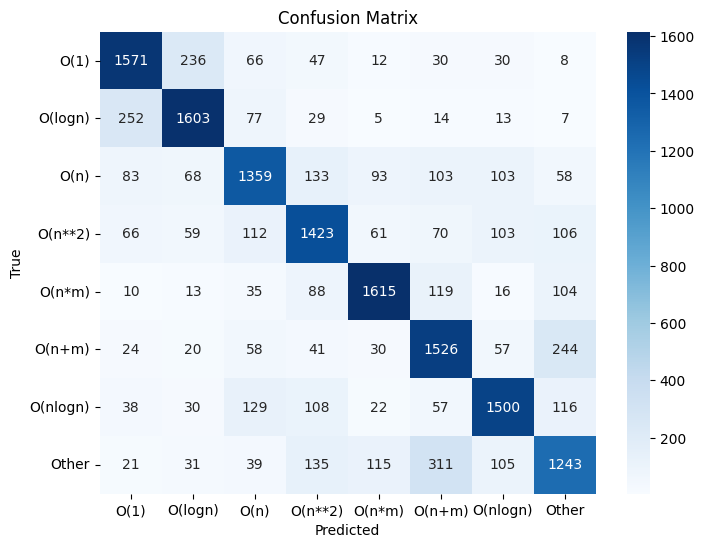

In [118]:
cm = confusion_matrix(test_target, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=time_encoder.classes_, yticklabels=time_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Key observations from the results:
- The classes O(1), O(logn), O(nlogn), and O(n*m) show relatively high precision and recall, indicating strong performance on common or more distinguishable patterns.
- The O(n), O(n²) and O(n+m) classes have slightly lower scores, possibly due to overlaps or ambiguous code patterns that make them harder to separate.
- The "Other" class performs the worst, which is expected since it acts as a catch-all for rare or less-defined complexities.

The confusion matrix shown above complements the report by highlighting the specific misclassification trends, such us the higher confusion for the "Other" class.

### Refine FineTuning

In this additional section, we attempt to further fine-tune the already pretrained model for a few additional epochs. The goal is to assess whether extending the training process could lead to marginal improvements in performance metrics such as accuracy and F1-score.

However, after retraining, we observe that the evaluation metrics deteriorate slightly compared to the original results. This suggests that the model is starting to overfit the training data, likely memorizing patterns rather than generalizing.

This highlights the importance of early stopping and careful monitoring of validation loss during fine-tuning to avoid performance degradation.

In [ ]:
#Load the model already finetuned for further processing 
model_path="/kaggle/working/codebert_large_finetuned"
time_model=AutoModelForSequenceClassification.from_pretrained(model_path)

We use the same confguration with a lower learning rate

In [122]:
from transformers import TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="/kaggle/working/results",
    eval_strategy="steps",    
    save_strategy="steps",            
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,         
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,  # increased epochs using early stopping
    learning_rate=5e-5,  #lower learning rate
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    fp16=True,
    report_to="none"
)


In [ ]:
trainer = Trainer(
    model=time_model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
  )

In [ ]:
trainer.train()

In [ ]:
# Save the fine-tuned model to disk
model_path = '/kaggle/working/codebert_large_finetuned_2'
time_model.save_pretrained(model_path)
# Save the tokenizer as well to ensure compatibility during inference
tokenizer.save_pretrained(model_path)

In [ ]:
# Zip the model directory for download
!zip -r codbert_large_finetuned_2.zip /kaggle/working/codebert_large_finetuned_2

We proceed here with the usual code for the evaluation

In [123]:
# Reload the fine-tuned model from the saved path
path= "/kaggle/input/codebert_model2/pytorch/default/1/kaggle/working/codebert_large_finetuned_2"
time_model = AutoModelForSequenceClassification.from_pretrained(path)
#print(time_model)

In [ ]:
# Recreate the Trainer with the same settings
trainer = Trainer(
    model=time_model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
  )

In [125]:
preds = trainer.predict(tokenized_data['test'])
preds

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


PredictionOutput(predictions=array([[-2.1492894e+00, -2.4415133e+00,  3.0158207e-01, ...,
         4.7371168e+00, -2.6688972e-01,  2.5675516e+00],
       [ 4.7302103e+00,  3.5609338e+00, -5.0106540e-02, ...,
        -3.2741845e+00,  1.9584927e-01, -1.9749955e+00],
       [ 3.3952360e+00,  5.7451897e+00,  1.3430741e+00, ...,
        -3.6085873e+00, -1.2207745e+00, -3.0281591e+00],
       ...,
       [-1.6071280e+00, -9.5824528e-01,  5.3001098e-02, ...,
        -1.5544195e+00,  7.2288532e+00, -1.5885514e+00],
       [-3.8246479e+00, -2.1217763e+00,  2.3984520e+00, ...,
        -1.2106335e+00, -2.2437060e+00,  4.0619316e+00],
       [-4.1940317e+00, -3.8431544e+00, -5.9388882e-01, ...,
        -5.5426890e-03,  2.9844601e+00,  4.3184047e+00]], dtype=float32), label_ids=array([5, 0, 1, ..., 6, 7, 5]), metrics={'test_loss': 0.8397141098976135, 'test_accuracy': 0.72575, 'test_precision': 0.728686600371266, 'test_recall': 0.72575, 'test_f1': 0.7248394056971461, 'test_runtime': 275.9175, 'test_

In [126]:
# Convert the predictions to a NumPy array
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
y_pred.shape
# Print the predictions shape to see if it matches the number of test samples
print("Predictions shape: ",y_pred.shape)

Predictions shape:  (16000,)


We can see below almost the same metrics values. (Slightly worse)

In [127]:
print(classification_report(test_target, y_pred, target_names=label_names))

              precision    recall  f1-score   support

        O(1)       0.76      0.77      0.76      2000
     O(logn)       0.75      0.80      0.77      2000
        O(n)       0.67      0.70      0.68      2000
     O(n**2)       0.72      0.69      0.70      2000
      O(n*m)       0.80      0.82      0.81      2000
      O(n+m)       0.65      0.79      0.72      2000
    O(nlogn)       0.84      0.68      0.75      2000
       Other       0.65      0.56      0.60      2000

    accuracy                           0.73     16000
   macro avg       0.73      0.73      0.72     16000
weighted avg       0.73      0.73      0.72     16000

